In [ ]:
# Operator Learning via Kernel Methods
#
# This is mostly a script for prototyping methods

In [27]:
# Imports
import numpy as np
import sklearn as skl
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import sys
sys.path.append('./')
from KLearn import *
from scipy import integrate
from functools import reduce
import matplotlib.pyplot as plt

In [28]:
# Define some Kernels
gamma = 50;
K = lambda y1,y2 : rbf_kernel(y1,y2, gamma = gamma)
S = lambda x1,x2 : rbf_kernel(x1.T,x2.T, gamma = 0.00001) # lame, for now

In [29]:
### Generating Data

## GP kernel

def gp_kernel(t, sigma):
  return np.exp( - (1/(2*sigma**2))*t**2)

N_mesh = 100
x = np.linspace(0,1, N_mesh) # fine grid for visualization
X = x.reshape((-1,1))

## compute pairwise distance matrix

dist_matrix = pairwise_distances( x.reshape(-1,1), x.reshape(-1,1))

## GP lengthscale
sigma = 0.1
Cov_matrix = gp_kernel(dist_matrix, sigma) + 1e-8*np.eye(N_mesh)
Cov_matrix = 1/2*(Cov_matrix + Cov_matrix.T)

Cov_matrix_sqrt = np.linalg.cholesky(Cov_matrix)

print(Cov_matrix_sqrt)

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.94911465e-01 1.00753094e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.79800709e-01 1.99462967e-01 1.43214977e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.42487329e-21 2.37845680e-20 2.76865921e-19 ... 4.61364539e-04
  0.00000000e+00 0.00000000e+00]
 [5.26916302e-22 8.93906267e-21 1.05764543e-19 ... 1.34892945e-03
  4.61362146e-04 0.00000000e+00]
 [1.92874984e-22 3.32518594e-21 3.99848399e-20 ... 3.14672377e-03
  1.34891944e-03 4.61361198e-04]]


In [62]:
## Training and test functions

N_train = 1000    # Number of training functions
N_test  = 5     # Number of testing functions
u_train = np.zeros((N_mesh, N_train))
u_test  = np.zeros((N_mesh, N_test))

for i in range(N_train):
  xi = np.random.randn(N_mesh)
  u_train[:, i] = np.dot(Cov_matrix_sqrt, xi)

for i in range(N_test):
  xi = np.random.randn(N_mesh)
  u_test [:, i] = np.dot(Cov_matrix_sqrt, xi)
    
u_train = u_train*1./np.linalg.norm(u_train, axis=0)
u_test = u_test*1./np.linalg.norm(u_test, axis=0)
    
# define pointwise operator

def op_square(u):
  return u**2

def op_sin(u):
    return np.sin(u)

def op_I(u):
    return u

def op_diff(u,x):
    return np.gradient(u, x, axis=0)

def op_int(u,x,N_mesh,N):
    ints = np.zeros((np.shape(u)))
    idx = []
    for i in range(0, N_mesh):
        idx.append(i)
        ints[i][:] = integrate.simpson(u[idx][:], x[idx], axis = 0)
    return ints

# v_train = op_int(u_train,X,N_mesh,N_train)
# v_test  = op_int(u_test,X,N_mesh,N_test)

#v_train = op_diff(u_train,x)
#v_test  = op_diff(u_test,x)

v_train = op_sin(u_train)
v_test  = op_sin(u_test)

In [63]:
# Finish setting up
U = u_train;
V = v_train;
Y = x.reshape((-1, 1));

print(np.shape(U))
print(U)
print(np.shape(V))
print(np.shape(Y))

(100, 1000)
[[-0.03316009  0.04289717 -0.02797661 ...  0.02676428  0.11986801
  -0.03580933]
 [-0.03125607  0.04326473 -0.03843665 ...  0.02874028  0.11527297
  -0.0433821 ]
 [-0.02745362  0.04038945 -0.0502499  ...  0.0299972   0.11113175
  -0.05284755]
 ...
 [-0.12282577  0.01849604  0.08102922 ...  0.16364904  0.12665379
  -0.23046795]
 [-0.11217268  0.04829685  0.06202909 ...  0.18231085  0.11180559
  -0.24060312]
 [-0.1020017   0.07714664  0.04084438 ...  0.19943937  0.09451524
  -0.24545236]]
(100, 1000)
(100, 1)


In [64]:
# LEARN!
D,f = KLearn(U,V,N_mesh,S,K,Y)

In [65]:
# Does it work... ?
v_mod = D(u_test);
np.max(np.abs(v_mod(Y) - v_test)) # very nice...

0.0034450961366992994

In [66]:
# Define some Kernels again (this time, parameterized)
K_ = lambda g: (lambda y1,y2 : rbf_kernel(y1,y2, gamma = g))
S_ = lambda s : (lambda x1,x2 : rbf_kernel(x1,x2, gamma = s)) # lame, for now
kgrid = np.linspace(10,200, 100)
sgrid = 1/np.power(1.8,range(1,50))

In [67]:
# LEARN AGAIN!
D2,scoresS,gS = OpLearn(U,V, S_,sgrid, K_, kgrid,Y, report_scores=True)
print(scoresS) # THESE ARE THE CV SCORES (currently rel. MSE)
v_mod2,scoresK,gK = D2(u_test);

# Does it work... ?
np.max(np.abs(v_mod2(Y) - v_test)) # very nice...

Optimal gamma = 0.016333996728810075
[5.2525202894789475e-06, 2.110355228732401e-06, 9.365315779482639e-07, 4.839406908302731e-07, 3.208838020018676e-07, 2.5811650726788906e-07, 2.4065577385724113e-07, 2.8641060278922093e-07, 4.1118534149612854e-07, 6.410152019176301e-07, 1.0201540914339966e-06, 1.4895446594790914e-06, 1.775586833189402e-06, 1.8440760093175967e-06, 1.8412288545389308e-06, 1.8255952240962045e-06, 1.8117133708158121e-06, 1.806048013895067e-06, 1.8162645582171187e-06, 1.8530057751324842e-06, 1.928698526222995e-06, 2.063414696186951e-06, 2.28998506011925e-06, 2.654604400186996e-06, 3.2181495732314144e-06, 4.059584274887296e-06, 5.280848129549749e-06, 7.015134432021031e-06, 9.444244226613996e-06, 1.2824025969397163e-05, 1.7514436968873536e-05, 2.4024007933693628e-05, 3.30990806821971e-05, 4.5868470027538906e-05, 6.398666788648702e-05, 8.97422115186762e-05, 0.00012608020491693494, 0.00017618333522903632, 0.00024212322343047384, 0.00032259839525855663, 0.0004109269212074272, 

0.00033015090003030156

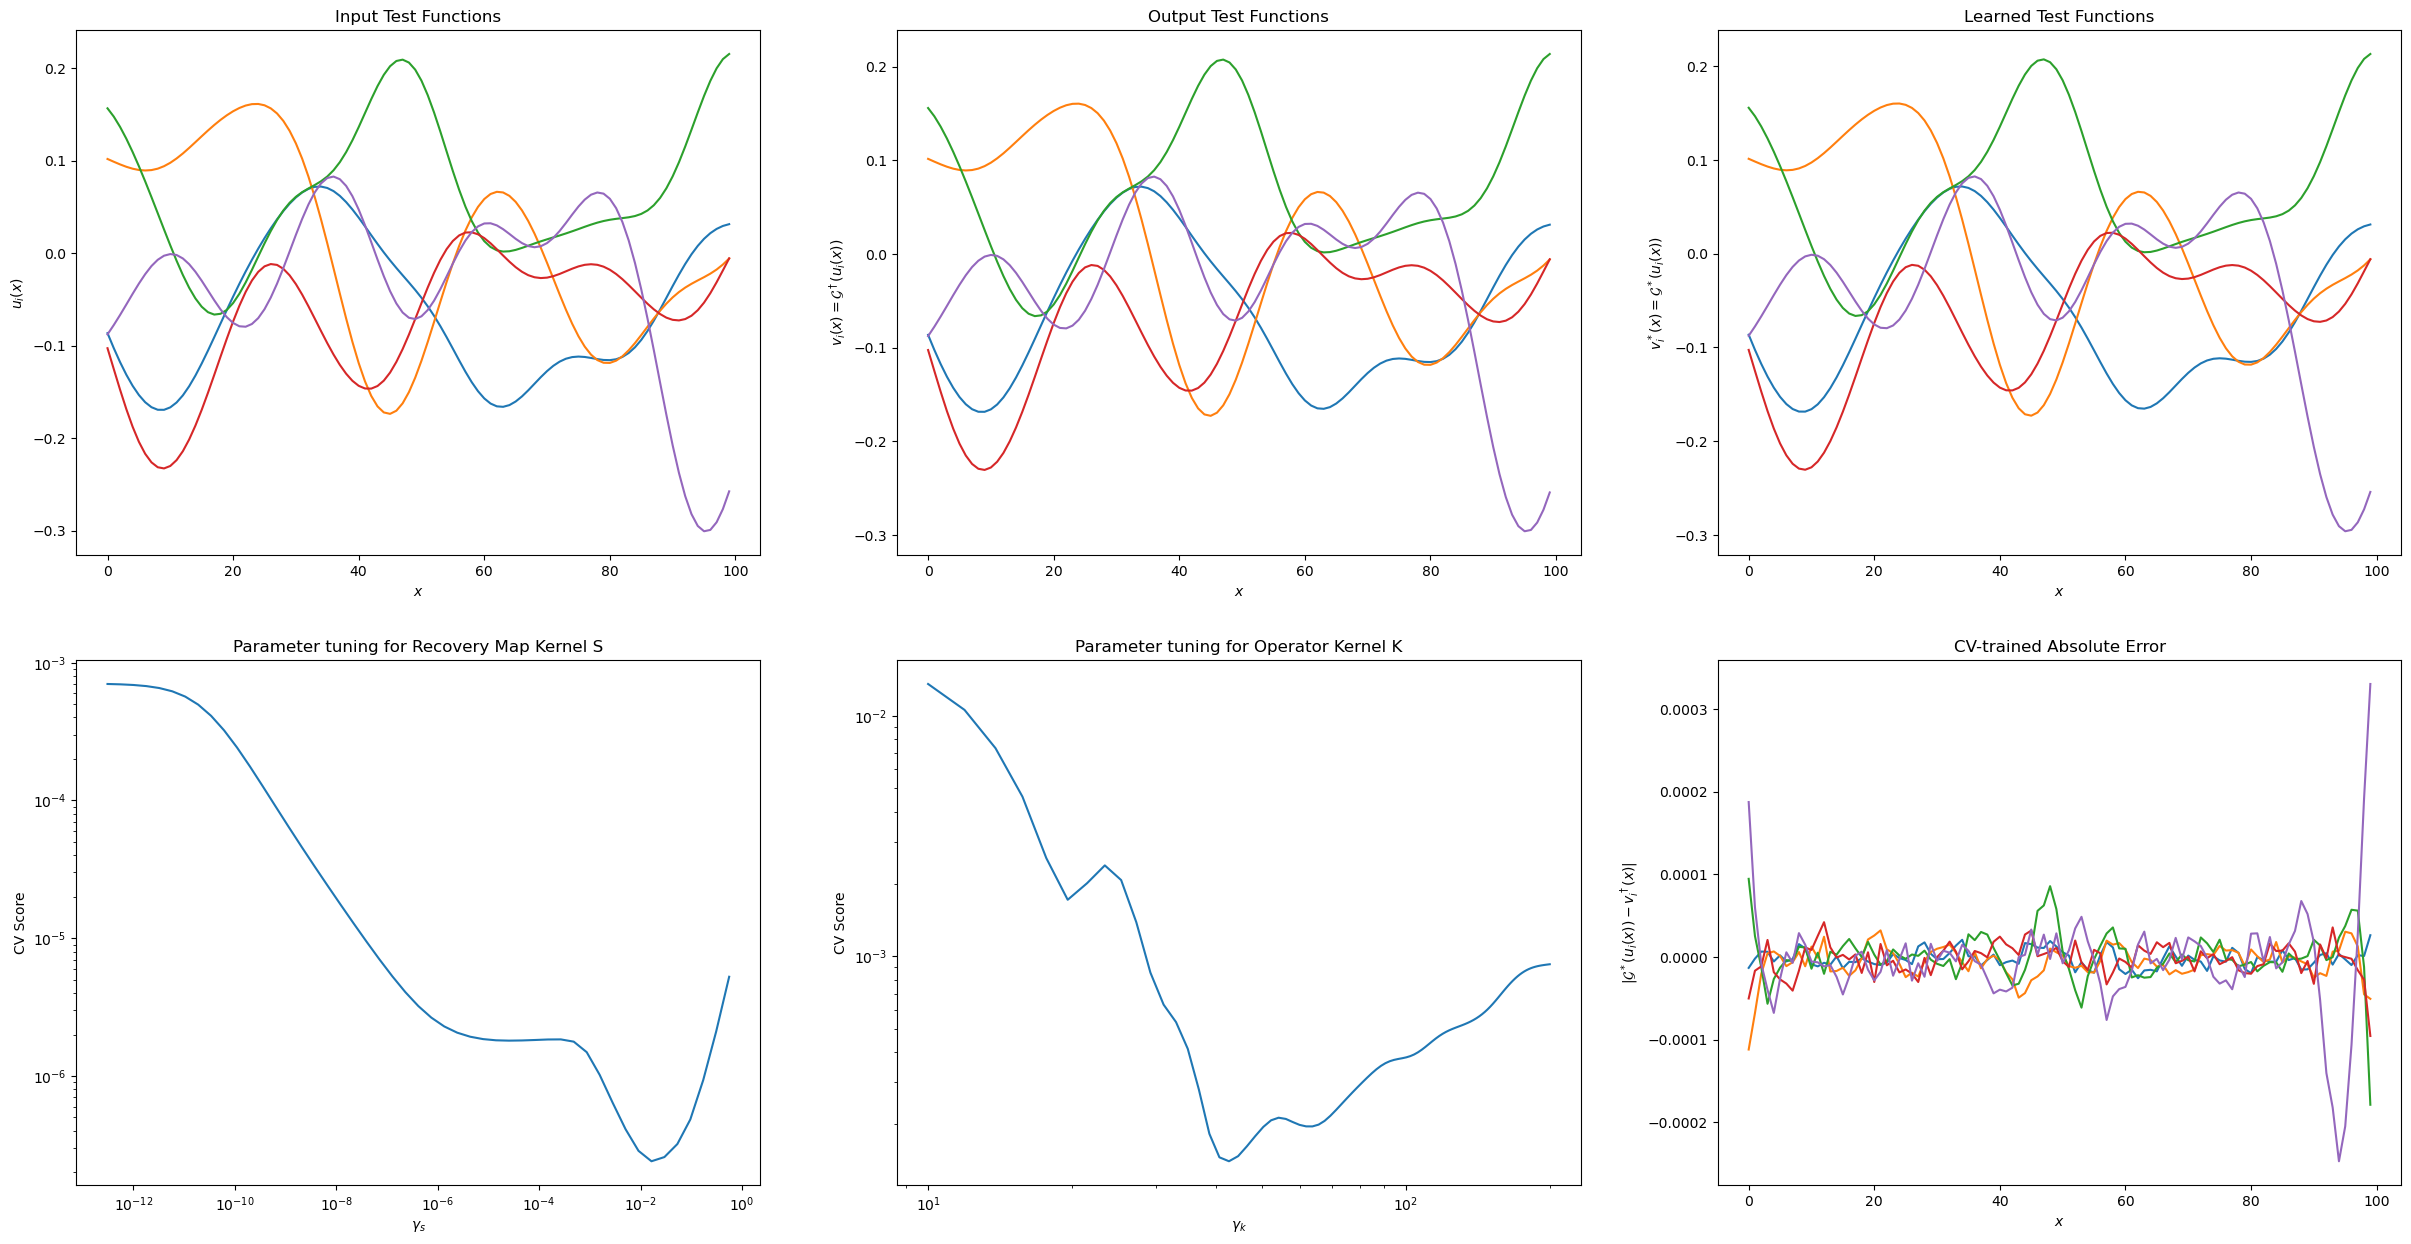

In [68]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(30,15)

ax[0,0].plot(u_test)
ax[0,0].set( xlabel ='$x$', ylabel='$u_i(x)$', title = "Input Test Functions")

ax[0,1].plot(v_test)
ax[0,1].set( xlabel ='$x$', ylabel='$v_i(x) = \mathcal{G}^\dagger (u_i(x))$', title = "Output Test Functions")

ax[0,2].plot(v_mod2(Y))
ax[0,2].set( xlabel ='$x$', ylabel='$v^*_i(x) = \mathcal{G}^*(u_i(x))$', title = "Learned Test Functions")

ax[1,0].loglog(sgrid, scoresS)
ax[1,0].set( xlabel ='$\gamma_s$', ylabel='CV Score', title = "Parameter tuning for Recovery Map Kernel S")

ax[1,1].loglog(kgrid, scoresK)
ax[1,1].set( xlabel ='$\gamma_k$', ylabel='CV Score', title = "Parameter tuning for Operator Kernel K")

ax[1,2].plot(v_mod2(Y)-v_test)
ax[1,2].set( xlabel ='$x$', ylabel='$|\mathcal{G}^*(u_i(x)) - v^\dagger_i(x)|$' , title = "CV-trained Absolute Error")


fig.savefig('Sin_Operator.png', dpi=300, bbox_inches='tight')

In [ ]:
# Let's plot the errors
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].loglog(sgrid, scoresS)
ax[0].set( xlabel ='$\gamma_s$', ylabel='CV Score', title = "Parameter tuning for Recovery Map Kernel S")

ax[1].loglog(kgrid, scoresK)
ax[1].set( xlabel ='$\gamma_k$', ylabel='CV Score', title = "Parameter tuning for Operator Kernel K")

fig.savefig('Int_Operator_CV.png', dpi=300, bbox_inches='tight')


fig, ax = plt.subplots(2,2)
fig.set_size_inches(25,15)

ax[0,0].plot(u_test)
ax[0,0].set( xlabel ='$x$', ylabel='$u_i(x)$', title = "Input Test Functions")

ax[1,0].plot(v_test)
ax[1,0].set( xlabel ='$x$', ylabel='$v_i(x) = \mathcal{G}^\dagger (u_i(x))$', title = "Output Test Functions")

ax[1,1].plot(v_mod2(Y))
ax[1,1].set( xlabel ='$x$', ylabel='$v^*_i(x) = \mathcal{G}^*(u_i(x))$', title = "Learned Test Functions")

ax[0,1].plot(v_mod2(Y)-v_test)
ax[0,1].set( xlabel ='$x$', ylabel='$|\mathcal{G}^*(u_i(x)) - v^\dagger_i(x)|$' , title = "CV-trained Absolute Error")

fig.savefig('I_Operator_Results.png', dpi=300, bbox_inches='tight')